# Assignment 1: Eigenvalue Decomposition of Handwritten Digits
John Duncan  
CS 391L: Machine Learning  
Instructor: Ballard  
Spring 2020

## Introduction

This project explores the method of Eigenvalue decomposition as applied to the classification of annotated data. Eigenvalue decomposition is a form of Principal Component Analysis (PCA), a machine learning technique that is relatively simple in concept and implementation.

Specifically, this assignment uses the _MNIST_ handwritten digits dataset&ndash;consisting of images of handwritten digits and their labels. The annotated data is decomposed into its principal components: its eigenvalues and eigenvectors. The eigenvectors of the training data are used to train train a K-nearest-neighbors (KNN) style classifier. The KNN classifier is then used to classify a set of unknown, labeled test data.

The number of training images, eigenvectors, and neighbors used in the classifier are varied to show the effects that these variables have on overall training accuracy. The algorithm was implemented as a _Jupyter Notebook_ using _Python 3_ for data handling, and Markdown for annotating the Python code.

## Method

This section discusses the theory behind the decomposition and classification of the training data, as well as the specific Python implementation. First, each of the required Python functions are discussed and defined. Then, a main loop calls these functions to decompose the training data, build the classifier, classify the test data, and determine the accuracy of the classifier.

### Import Python Packages

Consistent with Python convention, the required packages are imported at the beginning of the Python code. This project requires various functions, which are implemented using the following Python packages:

| Required Functionality             | Python Package                          |
|:----------------------------------:|:---------------------------------------:|
| Importing data                     | _scipy.io_                              |
| Matrix operations, data processing | _numpy_                                 |
| Image display & formatting         | _PIL.Image_                             |
| Data classification                | _sklearn.neighbors.KNeighborsClassifier_|
| Data plotting and display          | _matplotlib.pyplot_                     |

Python implementation follows:

In [1]:
# Import packages
import scipy.io as spio # An Input/Output module for obtaining MATLAB data within Python
import numpy as np # Matrix manipulation, data processing
from PIL import Image # Used to display, format, and save images
from sklearn.neighbors import KNeighborsClassifier # The KNN classifier package
import matplotlib.pyplot as plt # Used to plot data

### Derive and implement functions
Consistent with Python convention, functions are defined after packages are imported.

The first algorithm is to decompose the training data into its principal components: its eigenvalues and associated eigenvectors.

To perform the eigen-decomposition, begin with an $[n x m]$ matrix of training data, $A$, where each of the $m$ columns represents a training image, and each of the $n$ rows represents a pixel in that image.

$A$ can be reduced to a lower dimension by computing its covariance:
$A_{red} = cov[A] = E[(A_i-M)(A_i-M)^T]$, where $A_i$ is the $i^{th}$ column of $A$, and $M$ is the mean value of all columns $A_i$. The resultant $A_{red}$ is symmetric and square of dimension $[n x n]$, resulting in real-valued eigenvalues and eigenvectors. In Python, these operations can be performed by the _numpy_ package.

The eigenvalues and eigenvectors of $A_{red}$ can be computed using _numpy_'s linear algebra package, and form the basis set of the training dataset, $A$. Since the majority of the eigenspace can be spanned by only a few eigenvectors, the $n$-dimensional eigenspace can be approximated by $T$ vectors with the highest associated eigenvalues.

In other words, the majority of information in $A$ is contained in a fraction of its principal components. Extracting these is accomplished in Python by sorting the eigenvectors in descending eigenvalue-order with _argsort()_, then truncating the $[n x n]$ eigenvector matrix to the first $T$ column vectors.

The *find\_eigendigits* function returns $M$, $A_{red}$, and an $[n x T]$ eigenvector matrix, $A_{vectors}$. Note that the _numpy.linalg.eig()_ method returns normalized eigenvectors.

In [2]:
def find_eigendigits(A, T):
    
    # Compute the integer mean of each column. newaxis and transpose convert M into a nx1 column vector
    M = np.mean(A, axis=1)[np.newaxis].transpose()

    # Subtract the mean from A
    A_minus_M = np.subtract(A,M)
    
    # Reduce the subspace of A from nxm to nxn by multiplying it by itself
    A_reduced = np.matmul(A_minus_M,A_minus_M.transpose())
    
    # Find eigenvectors and eigenvalues of the reduced A matrix
    A_values, A_vectors = np.linalg.eig(A_reduced)
    
    # Sort eigenvectors and eigenvalues in descending order using argsort()
    eig_index = A_values.argsort()[::-1]   
    A_values = A_values[eig_index]
    A_vectors = A_vectors[:,eig_index]
    
    # Truncate eigenvector matrix and eigenvalue vector
    A_vectors = A_vectors[:,:T]
    A_values = A_values[:T]

   
    return M, A_vectors, A_reduced

Viewing the principal components of $A_{red}$ can be accomplished by projecting it into the $T$-dimensional eigenspace $A_{red}*A_{vectors}$, then converting each column into an image.

The _numpy_ and _PIL.Image_ packages can be used for this purpose:

In [3]:
def visualize_eigendigits(A_reduced, A_vectors, T):
     
    # Initialize empty image array
    img_array=np.zeros((28,1),dtype=np.float32)
    
    # Project reduced-order A matrix into eigenspace
    V = np.matmul(A_reduced,A_vectors)
    
    # Generate images of all T eigenvectors
    for index in range(T):
        vec = V[:,index] # Extract eigenvector
        array = np.reshape(vec,[28,28]) # Reshape eigenvector into a square image
        
        img_array_loop = img_array
        img_array = np.append(img_array_loop, array, axis=1) # Add the current eigenvector image to an array
        
    img = Image.fromarray(img_array, 'F')
    return img # Return the image which contains all T eigenvectors, side-by-side

To verify the efficacy of the eigen-decomposition, the training matrix $A$ can be directly compared with a $[nxm]$ matrix $A_{reconstructed}$. $A_{reconstructed}$ is the projection of $A$ into the reduced-order eigenspace, and is computed as follows:
$(A-M)_{reconstructed} = A_{vectors}A_{vectors}^T(A-M)$

$A_{reconstructed}$ effectively contains only the information in the first $T$ eigenvectors of $A$.

In [4]:
def reconstruct_data(A_vectors, A, M):
    
    # Subtract A from M
    A_minus_M = np.subtract(A,M)
    
    # Project all the A-M training data [nxm] onto a [Txm] subspace
    A_projected = np.matmul(A_vectors.transpose(),A_minus_M)
    
    # Now, multiply the nxT eigenvector matrix with the Txm projection to give a reconstruction of A-M [nxm]
    A_minus_M_reconstructed = np.matmul(A_vectors,A_projected)
    
    # Add mean value M, to reconstruct A, the nxm measurement matrix
    A_reconstructed = np.add(A_minus_M_reconstructed,M)
    
    return A_reconstructed, A_projected

Visualizing the reconstructed training data $A_{reconstructed}$ is again accomplished by extracting a column from the matrix and reshaping it into an image. This function also extracts the actual training image used for a side-by-side comparison.

The *visualize_reconstruction* function uses _numpy_ and _PIL.Image_ packages to accomplish this.

In [5]:
def visualize_reconstruction(indices, A, A_reconstructed):
    
    # Initialize empty image array
    img_array=np.zeros((28,1),dtype=np.float32)
    
    # For a range of indices
    for index in indices:
              
        # Extract the actual and reconstructed image data vectors
        actual_img_vec = A[:,index]
        recons_img_vec = A_reconstructed[:,index]
        
        # Reshape the n^2 x 1 image vectors into nxn arrays
        actual_img_array = np.reshape(actual_img_vec,[28,28])
        recons_img_array = np.reshape(recons_img_vec,[28,28])
        
        # Append the two arrays to give a side-by-side comparison of actual & reconstructed digits
        comparison_array = np.append(actual_img_array, recons_img_array, axis=1)
        
        # Add this pair of images to an array with all images
        img_array_loop = img_array
        img_array = np.append(img_array_loop, comparison_array, axis=1)
    
    # Convert an array into an image and return
    img = Image.fromarray(img_array, 'F')
    return img

Lastly, a K-Nearest-Neighbor (KNN) classifier is created to label the test data and evaluate the accuracy of the trained model. Like eigen-decomposition, KNN classification is conceptually simple. The test data and labeled training data are projected onto the $T$-dimensional eigenspace. The distance between unlabeled test data and its $k$ nearest neighbors is computed. The test data is labeled as the majority of its $k$ nearest neighbors. This implementation calculates the _Euclidean_ distance to the nearest neighbors of the test data, although other metrics could be used as well.

A KNN classifier is easily implemented in Python using the KNeighborsClassifier class from the _sklearn.neighbors_ package. The classification algorithm is implemented in the *classify_data* function, which accepts the following inputs:

* $k$, the number of neighbor distances to calculate for each test point (integer)
* $A_{projected}$, the training data projected onto the reduced eigenspace ($[Txm]$ matrix)
* $A_{labels}$, labels for the projected training data ($m$-length array)
* $A_{vectors}$, the training data's normalized eigenvectors ($[nxT]$ matrix)
* $M$, the mean value of training data point ($[nx1]$ matrix)
* $test$_$images$, test images, not used to train the model ($[nx10000]$ matrix)
* $test$_$labels$, labels of the test data which are used to compute accuracy ($10000$-length array)

Recall that $m$ is the number of training images and $T$ is the number of eigenvectors used.

*classify_data* first creates a KNN object, then fits the labeled training data to a model. The zero-mean test data are projected into the eigenspace as follows:

$test$_$projected = A_{vectors}^T(test$_$images - M)$

Predicted labels are assigned to the projected test data based on the nearest neighbors. Lastly, these predicted labels are compared to provided labels by a boolean comparison (1 for a match, 0 if not). The sum of this boolean comparison is divided by 10,000 (the number of training points) to compute the accuracy rate.

In [6]:
def classify_data(k, A_projected, A_labels, A_vectors, M, test_images, test_labels):
    # Create a euclidean, k-NearestNeighbor object using the KNeighborsClassifier package
    knn = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
    
    # Fit the model, given the eigenspace-projected training data and training data labels
    knn.fit(A_projected.transpose(), A_labels)
            
    # Subtract mean from test data
    test_minus_M = np.subtract(test_images,M)
            
    # Project test data onto the eigendigit subspace
    test_projected = np.matmul(A_vectors.transpose(),test_minus_M)
    pred_labels = knn.predict(test_projected.transpose())
    
    # Compute accuracy for this run
    accuracy = sum(test_labels==pred_labels)/10000 # Create boolean comparison vector, sum it, and divide by 10000
    return accuracy

### Load and Pre-Process Data

With the required functions implemented, this section begins the process of loading and classifying data. Training data is provided on the course's Canvas page, and consists of 60,000 annotated training digits, and 10,000 labeled test digits. Each digit is 28x28 pixels of UINT8 data type (0-255 value). Since the data is provided in Matlab's .mat format, it was imported using the scipy.io module. 

The imported *data* is a Python dictionary which contains two matrices (test data and training data) and two arrays (test_labels and training_labels). These arrays and matrices are extracted from the *data* dictionary for further processing.

Specifically, *test_images* is a $28x28x1x60000$ array, which is reshaped into the desired $784x60000$ matrix, where each column pertains to an individual image. Other arrays and matrices are similarly reshaped. In addition, training data is converted to a np.float32 data type; the original uint8 data resulted in roundoff errors during later processing steps.

In [7]:
# Import data
data = spio.loadmat('../data/digits.mat');

# Extract relevant data into arrays and matrices
test_images = data['testImages'];
test_labels = data['testLabels'];
train_images = data['trainImages'];
train_labels = data['trainLabels'];

# Shape and format data
A_full = np.reshape(train_images,[784,60000]).astype(np.float32);
labels_full = np.reshape(train_labels,[60000]);
test_images = np.reshape(test_images,[784,10000]);
test_labels = np.reshape(test_labels,[10000]);

### Main Loop

The functions and data above are all used in the main loop. The main loop varies the number of training data points, $m$, the number of eigenvalues, $T$, and the number of nearest neighbors, $k$, to label test data. The classification accuracy is computed for each $m,T,k$ combination, and stored in a dictionary structure.

Specifically, the loop iterates through various values of $m$, $T$, and $k$. At each step, the reduced, $nxm$ $A$ matrix is created by taking the first $m$ columns of the full $A$ matrix. The eigenvalues of this matrix are computed and saved as an image. Likewise, the training data is reconstructed in eigenspace, and selected reconstructed digits are saved in an image. Lastly, the classifier is created and used to classify the 10,000 test images. The resulting accuracy is saved and stored in a dictionary structure for later plotting.

In [9]:
# Select number of points to take
m_values = [500, 1000, 3000, 5000, 10000, 30000, 50000]; # Number of training data samples
T_values = [10, 15, 20, 25, 30]; # Number of eigenvalues to use
k_values = [6, 8, 10, 12, 14, 16] # Number of neighbors to use

# Initialize empty dictionary to store results
results = dict()

# Iterate through m (number of training points) 
for k in k_values:
    
    # Initialize dictionary structure with T as a key
    t_dict=dict()
    
    for T in T_values: # Iterate through T (number of eigenvectors to use)
        
        # Initialize loop counter and vectors for storing data
        ii=0
        m_vec=np.zeros(len(m_values)) # vector of m (number of training data points)
        acc_vec=np.zeros(len(m_values)) # vector of accuracy 
        
        for m in m_values: # Iterate through all values of training data points
        
            # Choose the training data and labels for this run
            A = A_full[:,:m]; # Reduce the full A_full matrix to a nxm matrix, A
            A_labels=labels_full[:m]
            
            # Find eigendigits for this training data set
            [M, A_vectors, A_reduced] = find_eigendigits(A, T)
            
            # Visualize eigendigits & save image file
            eig_img = visualize_eigendigits(A_reduced, A_vectors, T)
            eig_img = eig_img.convert('RGB')
            eig_img.save(eval("\"images/eigen_k" + str(k) + "T" + str(T) + "m" + str(m) + ".PNG\""))
            
            # Reconstruct training data in eigenspace
            A_reconstructed, A_projected = reconstruct_data(A_vectors, A, M)
            
            # Visualize selected reconstructed digits
            indices = [1,3,5,7,2,0,13,15,55,4]
            img = visualize_reconstruction(indices, A, A_reconstructed)
            img = img.convert('RGB')
            img.save(eval("\"images/recons_k" + str(k) + "T" + str(T) + "m" + str(m) + ".PNG\""))
            
            # Classify data and compute accuracy
            accuracy = classify_data(k, A_projected, A_labels, A_vectors, M, test_images, test_labels)
            
            # Store results in a 2D array for plotting
            m_vec[ii]=m
            acc_vec[ii]=accuracy
            
            # Increment loop count
            ii+=1
        
        # Store 2D arrays in a dictionary
        t_dict[T] = {'x': m_vec, 'y': acc_vec};
    
    # Store dictionary in a dictionary
    results[k] = t_dict

*results* contains the accuracy for a given combination of $m$, $T$, and $k$. The data dictionary *results[k][T].x* contains a vector of $m$ values, while *results[k][T].y* contains the associated accuracy result. The data are structured this way so that a single plot can be generated for a given value of $k$, with multiple series for each value of eigenvector $T$. However, this could be adjusted depending on the application.

In the following block of code, all the data are plotted and saved using the *matplotlib.plot* class.

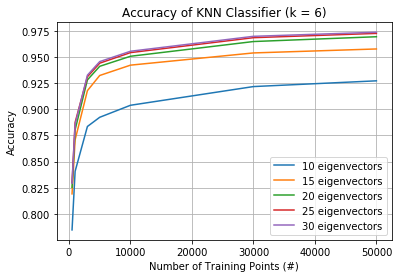

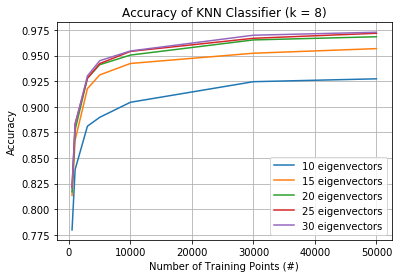

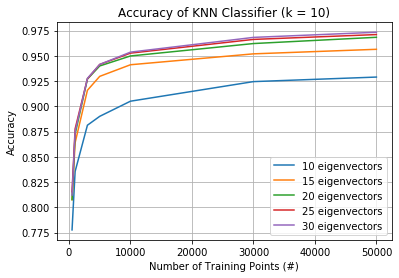

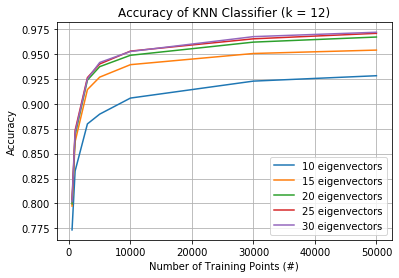

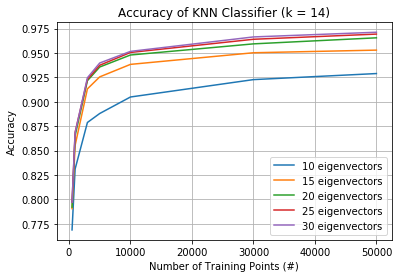

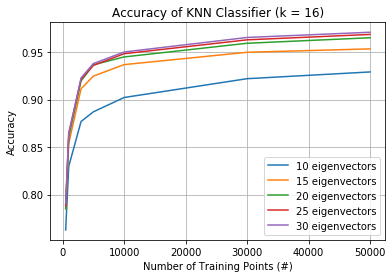

In [10]:
# Iterate through all values of k
for kk in k_values:
    
    # Create plot object
    fig, ax = plt.subplots()
    
    # Iterate through all values of T
    for tt in T_values:
        
        # Add data series for T and label it
        ax.plot(results[kk][tt]['x'],results[kk][tt]['y'],label=str(tt) + ' eigenvectors')
    
    # Create the figure
    ax.set(xlabel='Number of Training Points (#)', ylabel='Accuracy',
       title='Accuracy of KNN Classifier (k = '+ str(kk) +')')
    ax.grid()
    plt.legend()
    
    # Save figure
    fig.savefig("images/k" + str(kk) + ".PNG")
    # plt.show() # FOR DEBUGGING


## Results
The first 15 eigendigits are shown in the figure below for $m$=10000 training images:



Similarly, actual training images and their reconstructed equivalents with $T$=15 and $m$=10000 are shown below:


The accuracy of the classifier is shown in the following figures for $k$=[6,16], $T$=[10,30], and $m$=[500,50000]:

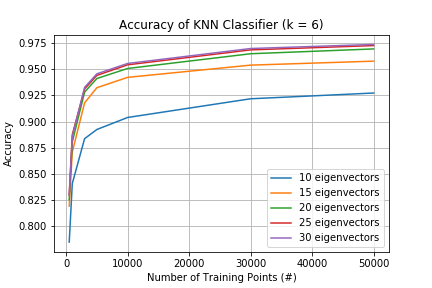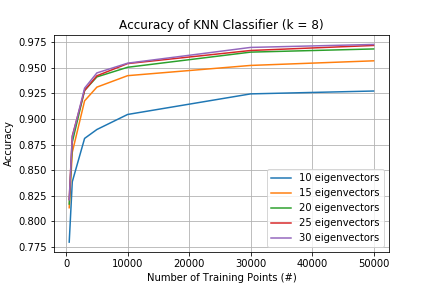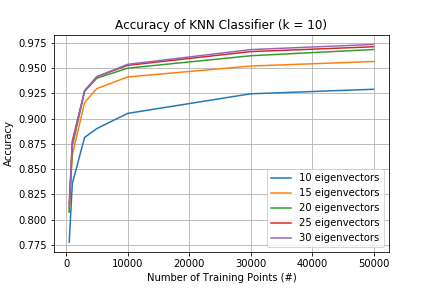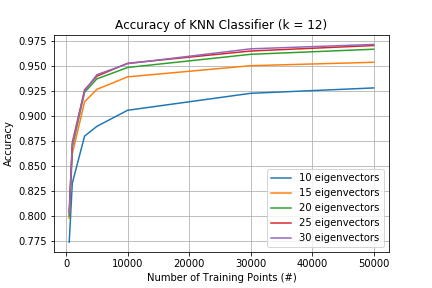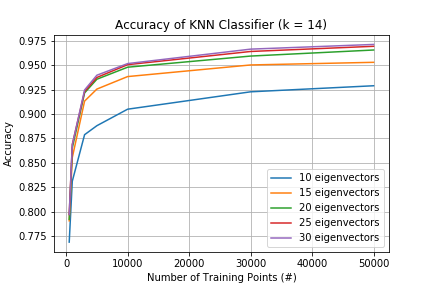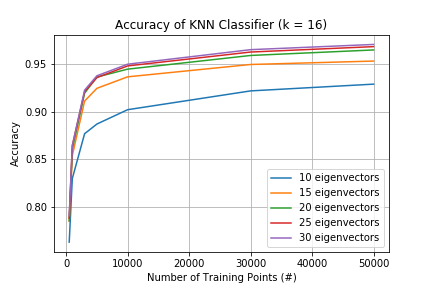



## Interpretation and Conclusions

Each of the variables $m$, $k$ and $T$ affect accuracy in a different way:
* $k$ provides maximum accuracy in the range of 8-10, which decreases as $k$ goes further from this range.
* Increasing $T$ provides large gains in accuracy as $T$ increases from 10 to 20. Increasing $T$ from 20 to 30 provides marginal accuracy improvement.
* Using the minimum value of $m$ = 500 training points, the model correctly predicted the test data >75% of the time for all combinations of $T$ and $k$. Increasing $m$ to 10,000 increases prediction accuracy to >90% in all tested cases. However, no tested cases exceeded 97.5% prediction accuracy.

Despite being a relatively simple classification method, eigen-decomposition and a KNN classifier yielded >75% accuracy for the lowest combination of values tested (500 training points, 10 eigenvalues, 6 neighbors). At no point did the eigen-decomposition/KNN classifier exceed 97.5% accuracy, suggesting a top-end performance limit for this configuration.

Overall, the classifier provides reasonable performance even when small amounts of training data are used; however, there are apparently upper boundaries to the classifier's performance. To increase prediction accuracy, the KNN parameters could be modified, or a new type of analysis could be used.